Importing All Essential Libraries

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings 
warnings.filterwarnings("ignore")
import pandas.util.testing as tm 

Since Our Dataset is Very Large. We hosted our dataset on cloud and Google Colab!

Import Library For Mounting Drive

In [0]:
from google.colab import drive

In [38]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Reading Dataset

In [0]:
df = pd.read_csv('/content/drive/My Drive/loan.csv')

**Data Cleaning**

Checking and Removing Columns With More Than 40% null values

In [40]:
check_null = df.isnull().sum(axis=0).sort_values(ascending=False)/float(len(df))
check_null[check_null>0.4]

id                                            1.000000
member_id                                     1.000000
url                                           1.000000
orig_projected_additional_accrued_interest    0.996273
hardship_start_date                           0.995305
hardship_end_date                             0.995305
payment_plan_start_date                       0.995305
hardship_length                               0.995305
hardship_dpd                                  0.995305
hardship_loan_status                          0.995305
hardship_payoff_balance_amount                0.995305
deferral_term                                 0.995305
hardship_last_payment_amount                  0.995305
hardship_status                               0.995305
hardship_reason                               0.995305
hardship_type                                 0.995305
hardship_amount                               0.995305
settlement_percentage                         0.985378
settlement

In [0]:
remove = ['dti_joint','verification_status_joint','annual_inc_joint','il_util','mths_since_rcnt_il',
          'total_cu_tl','all_util','open_il_12m','total_bal_il','open_il_24m','inq_last_12m',
          'inq_fi','open_acc_6m','open_rv_12m','max_bal_bc','open_rv_24m','mths_since_last_record',
          'mths_since_recent_bc_dlq','mths_since_last_major_derog','mths_since_recent_revol_delinq','desc',
         'mths_since_last_delinq']

In [0]:
df = df.drop(remove, axis=1)

In [0]:
df['annual_inc'] = df['annual_inc']/1000
df['loan_amnt'] = df['loan_amnt']/1000

Removing Last 2 Rows Which don't Contain Any Data

In [0]:
df = df[:-2]

Filling Null Values With 0

In [45]:
df = df.fillna(0)
null_count = df.isnull().sum()
null_count[null_count>0]

Series([], dtype: int64)

Removing All Symbols And Making Them Only Numeric Values

In [0]:
df['term'] = df['term'].str.replace('months','')
df['emp_length'] = df['emp_length'].str.replace('+','')
df['emp_length'] = df['emp_length'].str.replace('<','')
df['emp_length'] = df['emp_length'].str.replace('years','')
df['emp_length'] = df['emp_length'].str.replace('year','')

In [47]:
df.shape

(2260666, 123)

In [0]:
df['emp_length'] = pd.to_numeric(df['emp_length'])
df['emp_length'] = df.emp_length.fillna(0)
df['term'] = pd.to_numeric(df['term'])

Average Interest Rate For Each Grade

In [49]:
#Average interest rates for each grade.
pd.pivot_table(df, values='int_rate', index=['grade'])

,int_rate
grade,
A,7.084558
B,10.675819
C,14.143793
D,18.143283
E,21.829848
F,25.454203
G,28.074255


Loans Which are Fully Paid or Charged Off

In [0]:
df = df[(df["loan_status"] == "Fully Paid") |
                            (df["loan_status"] == "Charged Off")]

di = {"Fully Paid":0, "Charged Off":1}
df= df.replace({"loan_status": di})

In [0]:
df['term'] = np.where(df['term']==36, 1, 0)
df['delinq_2yrs'] = np.where(df['delinq_2yrs']>0, 1, 0)
df['inq_last_6mths'] = np.where(df['inq_last_6mths']>0, 1, 0)

In [52]:
categorical = df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

grade
7
sub_grade
35
emp_title
371436
home_ownership
6
verification_status
3
issue_d
139
pymnt_plan
1
purpose
14
title
61679
zip_code
944
addr_state
51
earliest_cr_line
738
initial_list_status
2
last_pymnt_d
135
next_pymnt_d
1
last_credit_pull_d
140
application_type
2
sec_app_earliest_cr_line
561
hardship_flag
2
hardship_type
2
hardship_reason
10
hardship_status
4
hardship_start_date
27
hardship_end_date
25
payment_plan_start_date
26
hardship_loan_status
6
disbursement_method
2
debt_settlement_flag
2
debt_settlement_flag_date
83
settlement_status
4
settlement_date
89


In [53]:
for col in df.columns:
    if (len(df[col].unique()) < 4):
        print(df[col].value_counts())
        print()

0.0    1303607
Name: id, dtype: int64

0.0    1303607
Name: member_id, dtype: int64

1    988754
0    314853
Name: term, dtype: int64

Source Verified    503726
Verified           407676
Not Verified       392205
Name: verification_status, dtype: int64

0    1041952
1     261655
Name: loan_status, dtype: int64

n    1303607
Name: pymnt_plan, dtype: int64

0.0    1303607
Name: url, dtype: int64

0    1052490
1     251117
Name: delinq_2yrs, dtype: int64

0    744275
1    559332
Name: inq_last_6mths, dtype: int64

w    751214
f    552393
Name: initial_list_status, dtype: int64

0.0    1303607
Name: out_prncp, dtype: int64

0.0    1303607
Name: out_prncp_inv, dtype: int64

0    1303607
Name: next_pymnt_d, dtype: int64

1    1303607
Name: policy_code, dtype: int64

Individual    1280370
Joint App       23237
Name: application_type, dtype: int64

N    1303606
Y          1
Name: hardship_flag, dtype: int64

0                                  1298272
INTEREST ONLY-3 MONTHS DEFERRAL       5335


Drop Columns Which Are Less Than 10% Of Total Rows/>80% Correlated

In [0]:
remove3 = ['id','grade','emp_title','url','title','zip_code','addr_state','earliest_cr_line','last_pymnt_d',
          'last_credit_pull_d','policy_code','application_type','pymnt_plan','issue_d','out_prncp','next_pymnt_d',
          'out_prncp_inv']

In [0]:
df = df.drop(remove3, axis=1)

Drop Columns Which Do Not Add Values

In [0]:
remove4 = ['member_id','funded_amnt','funded_amnt_inv','total_pymnt_inv','total_rec_prncp','total_rec_int',
          'total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt','recoveries',
          'collection_recovery_fee','collections_12_mths_ex_med','total_rev_hi_lim',
          'acc_open_past_24mths','bc_open_to_buy','bc_util','mo_sin_old_il_acct','mo_sin_old_rev_tl_op',
          'mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75','tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit']

In [0]:
df = df.drop(remove4, axis=1)

Correlation Between Different Variables

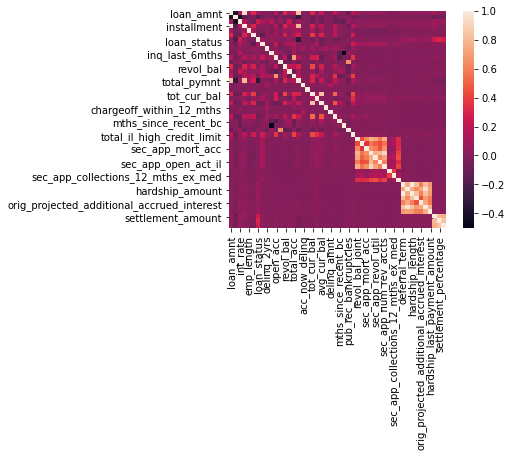

In [58]:
corrmat = df.corr()
#Find correlation between the different variables.
f, ax = plt.subplots()
sns.heatmap(corrmat,square=True)

In [59]:
df.columns.unique()

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'total_pymnt', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_act_il', 'avg_cur_bal', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'pub_rec_bankruptcies',
       'total_il_high_credit_limit', 'revol_bal_joint',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'hardship_flag', 'hardship_type',
       'hardship_reason', 'hard

In [0]:
remove5 = ['total_il_high_credit_limit','installment','revol_util','revol_bal','pub_rec',
           'delinq_amnt','avg_cur_bal','open_acc','total_acc','mort_acc','mths_since_recent_bc']
df = df.drop(remove5, axis=1)

Correlation Of All Variables Which We are going to use for Interest Rate Prediction

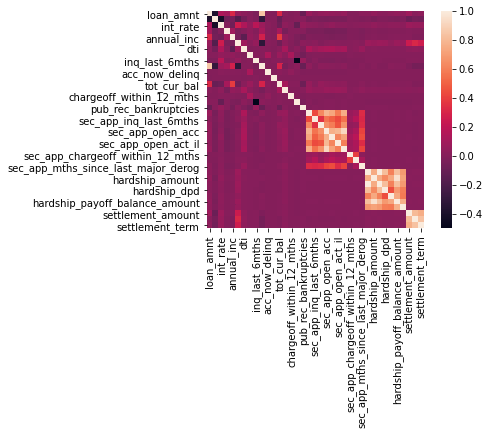

In [61]:
#Creating a correlation matrix.
corrmat = df.corr()
#Find correlation between the different variables.
f, ax = plt.subplots()
sns.heatmap(corrmat,square=True)

In [0]:
df = pd.concat([df.drop('home_ownership', axis=1), pd.get_dummies(df['home_ownership'])], axis=1)
df = pd.concat([df.drop('initial_list_status', axis=1), pd.get_dummies(df['initial_list_status'])], axis=1)
df = pd.concat([df.drop('purpose', axis=1), pd.get_dummies(df['purpose'])], axis=1)
df = pd.concat([df.drop('sub_grade', axis=1), pd.get_dummies(df['sub_grade'])], axis=1)
df = pd.concat([df.drop('verification_status', axis=1), pd.get_dummies(df['verification_status'])], axis=1)


Divide Dataset Into Testing And Training Data

In [0]:
from sklearn.model_selection import train_test_split

X=df[['loan_amnt','annual_inc','dti', 'emp_length', 'tot_cur_bal', 'term', 'inq_last_6mths']].values
y=df['int_rate'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Gradient Boosting Regressor For Prediction Of Interest Rate

In [66]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

algo = GradientBoostingRegressor(n_estimators=110)
print ("Number of inputs: ",len(y_train))
model = algo.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred=np.round(y_pred,2)
print ("Mean absolute error is: ")
print(metrics.mean_absolute_error(y_test, y_pred))
print
errors = []
for i,j in zip(y_test, y_pred):
    if abs(i-j)<3:
        errors.append(abs(i-j))


Number of inputs:  912524
Mean absolute error is: 
3.1314514054561307


In [0]:
A= 1-np.mean(errors)/ df.int_rate.mean()

Accuracy For Interest Rate Prediction

In [68]:
print('Accuracy for interest rate prediction is:' ,A*100)

Accuracy for interest rate prediction is: 89.27048266855105


In [71]:
for i,j in zip(y_test, y_pred):
  print(i,j)

Streaming output truncated to the last 5000 lines.
15.05 14.7
7.89 13.43
15.61 18.45
11.39 14.22
19.03 11.28
17.86 13.95
8.18 14.48
14.46 12.44
7.21 12.0
14.99 13.21
13.05 14.43
18.75 13.07
12.49 10.39
14.33 12.41
12.12 11.58
26.3 18.64
14.49 14.14
16.78 16.8
12.99 12.07
19.53 17.81
5.31 11.46
19.52 14.72
6.19 10.66
11.99 11.02
5.32 12.13
15.61 15.47
9.17 17.23
16.29 15.61
9.67 13.04
17.1 10.23
19.52 13.09
18.24 15.93
12.99 11.36
11.71 10.0
7.91 11.68
12.74 12.53
15.77 12.0
12.73 13.31
24.99 19.77
13.99 12.33
7.07 8.79
21.99 17.38
22.99 18.21
5.32 10.42
27.79 19.4
12.59 13.98
12.29 9.83
15.31 14.76
14.31 14.5
13.18 13.98
16.02 11.13
9.49 9.0
9.17 9.43
18.99 11.51
13.49 13.34
12.29 12.35
18.99 10.42
10.15 18.74
16.02 11.23
7.26 11.53
18.55 14.74
24.5 19.38
6.72 12.8
17.77 14.07
15.88 13.63
19.52 11.7
12.29 12.94
15.99 11.15
16.99 16.95
7.69 9.28
17.86 15.23
13.35 18.34
13.99 14.6
13.59 15.42
7.26 10.56
10.99 15.37
10.75 11.74
11.67 10.9
14.49 16.86
20.49 19.7
8.24 11.16
7.69 11.84
8.49 